# Complex body TFA Inversion

This notebook performs the inversion using Levenberg-Marquadt's algorithm of total field anomaly (TFA) data on a regular grid of a model with a complex geometry.

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import cPickle as pickle
import os

from fatiando import utils
from fatiando.gravmag import polyprism
from fatiando.vis import mpl

In [18]:
from datetime import datetime
today = datetime.today()
# dd/mm/YY
d4 = today.strftime("%d-%b-%Y-%Hh:%Mm")

### Auxiliary functions

In [19]:
import sys
sys.path.insert(0, '../../code')

import mag_polyprism_functions as mfun

# Input

### Importing model parameters

In [20]:
model_dir = 'data/thick_inter_body/model.pickle'
data_dir = 'data/thick_inter_body/data.pickle'

In [21]:
with open(model_dir) as w:
        model = pickle.load(w)

### Observation points and observed data

In [22]:
with open(data_dir) as w:
        data = pickle.load(w)

In [23]:
# observed data and observation points
dobs = data['tfa_obs']
xp = data['grid'][0]
yp = data['grid'][1]
zp = data['grid'][2]
N = data['grid'][3]

### Parameters of the initial model

In [54]:
M = 20 # number of vertices per prism
L = 10 # number of prisms
P = L*(M+2) + 1 # number of parameters

# depth to the top, thickness, origin, magnetization and radius
incs = model['inc']
decs = model['dec']
intensity = model['intensity']
z0 = model['z0']
dz = 650.
r = 800.
x0 = -300.
y0 = 300.

# main field
inc, dec = data['main_field']

model0, m0 = mfun.initial_cylinder(M, L, x0,
        y0, z0, dz, r, inc, dec, incs, decs, intensity)

# predict data
d0 = polyprism.tf(xp, yp, zp, model0, inc, dec)

In [55]:
intensity

12.0

In [56]:
model['intensity']

12.0

### Limits

In [57]:
# limits for parameters in meters
rmin = 10.
rmax = 3000.
x0min = -4000.
x0max = 4000.
y0min = -4000.
y0max = 4000.
dzmin = 200.
dzmax = 1000.

mmin, mmax = mfun.build_range_param(M, L, rmin, rmax, x0min, x0max, y0min, y0max, dzmin, dzmax)

### Variation

In [58]:
# variation for derivatives
deltax = 0.01*np.max(100.)
deltay = 0.01*np.max(100.)
deltar = 0.01*np.max(100.)
deltaz = 0.01*np.max(100.)

### Outcropping parameters

In [45]:
# outcropping body parameters
m_out = np.zeros(M + 2)
#m_out = model['param_vec'][:M+2]

In [31]:
# output of inversion
inversion = dict()

### Regularization parameters

In [59]:
#lamb = th*0.01 # Marquadt's parameter
lamb = 10.0
dlamb = 10.      # step for Marquadt's parameter

a1 = 1.0e-4  # adjacent radial distances within each prism
a2 = 1.0e-4   # vertically adjacent radial distances
a3 = 0.     # outcropping cross-section
a4 = 0.     # outcropping origin
a5 = 1.0e-4    # vertically adjacent origins
a6 = 1.0e-8   # zero order Tikhonov on adjacent radial distances
a7 = 1.0e-7     # zero order Tikhonov on thickness of each prism

In [60]:
delta = np.array([deltax, deltay, deltar, deltaz])
alpha = np.array([a1, a2, a3, a4, a5, a6, a7])

In [61]:
itmax = 30
itmax_marq = 10
tol = 1.0e-4     # stop criterion

In [62]:
inversion['x'] = xp
inversion['y'] = yp
inversion['z'] = zp
inversion['observed_data'] = dobs

In [63]:
inversion['inc_dec'] = [incs, decs]
inversion['z0'] = z0
inversion['initial_dz'] = dz
inversion['intial_r'] = r
inversion['initial_estimate'] = model0
inversion['initial_data'] = d0
inversion['limits'] = [rmin, rmax, x0min, x0max, y0min, y0max, dzmin, dzmax]
inversion['regularization'] = np.array([a1, a2, a3, a4, a5, a6, a7])
inversion['tol'] = tol
inversion['main_field'] = [-21.5, -18.7]

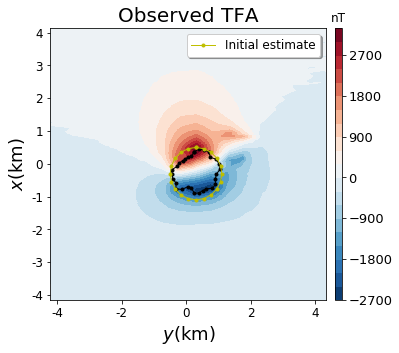

In [64]:
plt.figure(figsize=(6,5))
plt.title('Observed TFA', fontsize=20)
plt.tricontourf(yp, xp, dobs, 20, cmap='RdBu_r').ax.tick_params(labelsize=12)
plt.xlabel('$y$(km)', fontsize=18)
plt.ylabel('$x$(km)', fontsize=18)
clb = plt.colorbar(pad=0.025, aspect=40, shrink=1)
clb.ax.tick_params(labelsize=13)
source = mpl.polygon(model['prisms'][0], '.-k', xy2ne=True)
estimate = mpl.polygon(model0[0], '.-y', xy2ne=True)
#source.set_label('Outcropping polygon')
estimate.set_label('Initial estimate')
clb.ax.set_title('nT')
mpl.m2km()
plt.legend(loc=0, fontsize=12, shadow=bool, framealpha=1)
#plt.savefig(mypath+'diorama_tfa_pred_data_true_inital.png', dpi=300)
plt.show()

#img(filename=mypath+'diorama_tfa_pred_data_true_inital.png', width=1000, height=1200)

In [65]:
np.sum(dobs)

8722.610267935834

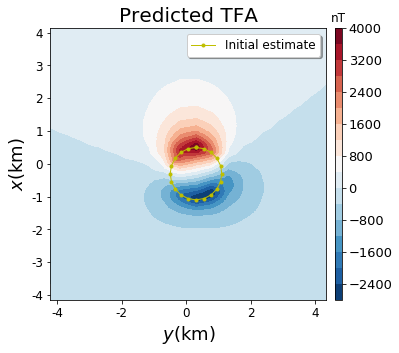

In [66]:
plt.figure(figsize=(6,5))
plt.title('Predicted TFA', fontsize=20)
plt.tricontourf(yp, xp, d0, 20, cmap='RdBu_r').ax.tick_params(labelsize=12)
plt.xlabel('$y$(km)', fontsize=18)
plt.ylabel('$x$(km)', fontsize=18)
clb = plt.colorbar(pad=0.025, aspect=40, shrink=1)
clb.ax.tick_params(labelsize=13)
estimate = mpl.polygon(model0[0], '.-y', xy2ne=True)
estimate.set_label('Initial estimate')
clb.ax.set_title('nT')
mpl.m2km()
plt.legend(loc=0, fontsize=12, shadow=bool, framealpha=1)
plt.show()

### Inversion

In [67]:
d_fit, m_est, model_est, phi_list, model_list, res_list = mfun.l1_levmarq_tf(
    xp, yp, zp, m0, M, L, delta,
    itmax, itmax_marq, lamb,
    dlamb, tol, mmin, mmax,
    m_out, dobs, inc, dec,
    model0[0].props, alpha, z0, dz
)

it:  0   it_marq:  0   lambda: 1e+01   init obj.: 8.49303e+01  fin obj.: 7.17077e+01
it:  1   it_marq:  0   lambda: 1e+00   init obj.: 7.17077e+01  fin obj.: 4.97591e+01
it:  2   it_marq:  0   lambda: 1e-01   init obj.: 4.97591e+01  fin obj.: 3.23126e+01
it:  3   it_marq:  0   lambda: 1e-02   init obj.: 3.23126e+01  fin obj.: 2.67426e+01
it:  4   it_marq:  0   lambda: 1e-03   init obj.: 2.67426e+01  fin obj.: 2.61999e+01
it:  5   it_marq:  0   lambda: 1e-04   init obj.: 2.61999e+01  fin obj.: 2.66515e+01
it:  5   it_marq:  1   lambda: 1e-03   init obj.: 2.61999e+01  fin obj.: 2.66791e+01
it:  5   it_marq:  2   lambda: 1e-02   init obj.: 2.61999e+01  fin obj.: 2.59237e+01
it:  6   it_marq:  0   lambda: 1e-03   init obj.: 2.59237e+01  fin obj.: 2.76873e+01
it:  6   it_marq:  1   lambda: 1e-02   init obj.: 2.59237e+01  fin obj.: 2.67985e+01
it:  6   it_marq:  2   lambda: 1e-01   init obj.: 2.59237e+01  fin obj.: 2.56014e+01
it:  7   it_marq:  0   lambda: 1e-02   init obj.: 2.56014e+01  fi

# Results

In [68]:
inversion['data_fit'] = d_fit
inversion['estimate'] = m_est
inversion['prisms'] = model_est
inversion['estimated_models'] = model_list
inversion['objective'] = phi_list
inversion['residual'] = dobs - d_fit
inversion['residual_list'] = res_list

### Folder to save the results

In [69]:
mypath = data_dir[:-11]+'l1_tfa_inversion/single-'+d4 #default folder name
# mypath = data_dir[:-11]+'l2_tfa_inversion/name_folder' #defined folder name
if not os.path.isdir(mypath):
   os.makedirs(mypath)

In [70]:
file_name = mypath+'/inversion.pickle'
with open(file_name, 'w') as f:
    pickle.dump(inversion, f)

In [71]:
mypath

'data/thick_inter_body/l1_tfa_inversion/single-11-Jul-2020-10h:23m'